In [2]:
# Imports
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

import random

In [3]:
# set_seed() and seed_worker()

def set_seed(seed=None, seed_torch=True):
	"""
    Function that controls randomness. NumPy and random modules must be imported.
  
    Args:
      seed : Integer
        A non-negative integer that defines the random state. Default is `None`.
      seed_torch : Boolean
        If `True` sets the random seed for pytorch tensors, so pytorch module
        must be imported. Default is `True`.
  
    Returns:
      Nothing.
    """
	if seed is None:
		seed = np.random.choice(2 ** 32)
	random.seed(seed)
	np.random.seed(seed)
	if seed_torch:
		torch.manual_seed(seed)
		torch.cuda.manual_seed_all(seed)
		torch.cuda.manual_seed(seed)
		torch.backends.cudnn.benchmark = False
		torch.backends.cudnn.deterministic = True

	print(f'Random seed {seed} has been set.')

	# In case that `DataLoader` is used
def seed_worker(worker_id):
	"""
    DataLoader will reseed workers following randomness in
    multi-process data loading algorithm.
  
    Args:
      worker_id: integer
        ID of subprocess to seed. 0 means that
        the data will be loaded in the main process
        Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details
  
    Returns:
      Nothing
    """
	worker_seed = torch.initial_seed() % 2**32
	np.random.seed(worker_seed)
	random.seed(worker_seed)

In [4]:
# set_device() to CPU or GPU

def set_device():
	"""
    Set the device. CUDA if available, CPU otherwise
  
    Args:
      None
  
    Returns:
      Nothing
    """
	device = "cuda" if torch.cuda.is_available() else "cpu"
	if device != "cuda":
		print("GPU is not enabled in this notebook. \n"
		      "If you want to enable it, in the menu under `Runtime` -> \n"
		      "`Hardware accelerator.` and select `GPU` from the dropdown menu")
	else:
		print("GPU is enabled in this notebook. \n"
		      "If you want to disable it, in the menu under `Runtime` -> \n"
		      "`Hardware accelerator.` and select `None` from the dropdown menu")

	return device

In [5]:
# Setting random the seed and device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Random seed 2021 has been set.


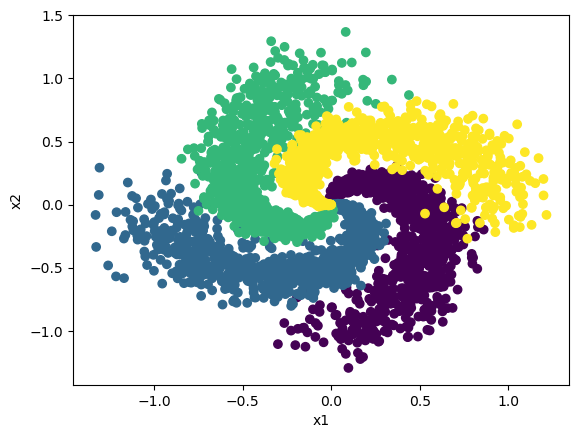

In [6]:
# Create spiral dataset

def create_spiral_dataset(K, sigma, N):
	"""
    Function to simulate spiral dataset
  
    Args:
      K: int
        Number of classes
      sigma: float
        Standard deviation
      N: int
        Number of data points
  
    Returns:
      X: torch.tensor
        Spiral data
      y: torch.tensor
        Corresponding ground truth
    """

	# Initialize t, X, y
	t = torch.linspace(0, 1, N)
	X = torch.zeros(K*N, 2)
	y = torch.zeros(K*N)

	# Create data
	for k in range(K):
		X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
		X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
		y[k*N:(k+1)*N] = k

	return X, y

# Set parameters
K = 4
sigma = 0.16
N = 1000

set_seed(seed=SEED)
X, y = create_spiral_dataset(K, sigma, N)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [26]:
# Net class

class Net(nn.Module):
	"""
    Simulate MLP Network
    """

	def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
		"""
        Initialize MLP Network parameters
    
        Args:
          actv: string
            Activation function
          input_feature_num: int
            Number of input features
          hidden_unit_nums: list
            Number of units per hidden layer. List of integers
          output_feature_num: int
            Number of output features
    
        Returns:
          Nothing
        """
		super(Net, self).__init__()
		self.input_feature_num = input_feature_num # Save the input size for reshaping later

		self.hidden_states = []
		self.hidden_outputs = []
		self.output_state = []
		self.processed_output = []

		self.hidden_activations = []

		layers = []
		prev_size = input_feature_num
		for hidden_size in hidden_unit_nums:
			layers.append(nn.Linear(prev_size, hidden_size))
			act_layer = actv()
			layers.append(act_layer)
			self.hidden_activations.append(act_layer)
			prev_size = hidden_size

		self.output_state_layer = nn.Linear(prev_size, output_feature_num)
		layers.append(self.output_state_layer) # Output state layer

		last_layer = actv()
		layers.append(last_layer) # ReLU after output state layer
		self.last_activation = last_layer

		self.mlp = nn.Sequential(*layers)

	def forward(self, x):
		"""
        Simulate forward pass of MLP Network
    
        Args:
          x: torch.tensor
            Input data
    
        Returns:
          logits: Instance of MLP
            Forward pass of MLP
        """
		
		self.hidden_states = []  # Clear previous hidden outputs
		self.hidden_outputs = []
		self.output_state = []
		self.processed_output = []

		hidden_states_batch = []
		hidden_outputs_batch = []

		for layer in self.mlp:
			x = layer(x)
			if isinstance(layer, nn.Linear) and layer != self.output_state_layer and layer != self.last_activation: 
				self.hidden_states.append(x.detach())  # Store state of hidden layers before activation 
			elif layer in self.hidden_activations:
				self.hidden_outputs.append(x.detach()) # Store state of hidden layers after activation
		
		self.output_state.append(x.detach())  # State of the last layer before activation
		x = self.last_activation(x)
		self.processed_output.append(x.detach())  # Output of the last layer after activation

		if hidden_states_batch:
			self.hidden_states.append(np.concatenate(hidden_states_batch, axis=0))
		if hidden_outputs_batch:
			self.hidden_outputs.append(np.concatenate(hidden_outputs_batch, axis=0))

		return x
	
	def reinit(self):
		self.hidden_states = [] 
		self.hidden_outputs = []
		self.output_state = []
		self.processed_output = []
	
	def test(self, data_loader, device='cpu'):
		"""
        Function to gauge network performance
    
        Args:
          data_loader: torch.utils.data type
            Combines the test dataset and sampler, and provides an iterable over the given dataset.
		  device: string
            CUDA/GPU if available, CPU otherwise
    
        Returns:
          acc: float
            Performance of the network
          total: int
            Number of datapoints in the dataloader
        """
		correct = 0
		total = 0
		for data in data_loader:
			inputs, labels = data
			inputs = inputs.to(device).float()
			labels = labels.to(device).long()

			outputs = self.forward(inputs)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

		acc = 100 * correct / total
		return total, acc
	
	def train_model(self, criterion, optimizer, train_loader, num_epochs=1, verbose=True, training_plot=False, device='cpu'):
		"""
		Accumulate training loss/Evaluate performance
	
		Args:
		  criterion: torch.nn type
		    Criterion combines LogSoftmax and NLLLoss in one single class.
		  optimizer: torch.optim type
		    Implements Adam algorithm.
		  train_loader: torch.utils.data type
		    Combines the train dataset and sampler, and provides an iterable over the given dataset.
		  test_loader: torch.utils.data type
		    Combines the test dataset and sampler, and provides an iterable over the given dataset.
		  num_epochs: int
		    Number of epochs [default: 1]
		  verbose: boolean
		    If True, print statistics
		  training_plot=False
		    If True, display training plot
		  device: string
		    CUDA/GPU if available, CPU otherwise
	
		Returns:
		  Nothing
		"""
		self.to(device)
		self.train()
		self.training_losses = []
		self.reinit()

		hidden_states_epoch = []
		hidden_outputs_epoch = []

		self.all_labels = torch.empty((1,))

		for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
			running_loss = 0.0
			epoch_hidden_states = []
			epoch_hidden_outputs = []
			for i, data in enumerate(train_loader, 0):
				# Get the inputs; data is a list of [inputs, labels]
				inputs, labels = data
				inputs = inputs.to(device).float()
				labels = labels.to(device).long()

				# Zero the parameter gradients
				optimizer.zero_grad()

				# forward + backward + optimize
				outputs = self.forward(inputs)

				# Decide criterion function
				criterion_function = eval(f"nn.{criterion}()")
				if criterion == "MSELoss":
					targets = torch.zeros((inputs.shape[0],4))
					for row in range(len(labels)):
						col = labels.int()[row]
						targets[row][col] = 1
					loss = criterion_function(outputs, targets)
				elif criterion == "CrossEntropyLoss":
					loss = criterion_function(outputs, labels)
					
				if self.all_labels.size == 1:
					self.all_labels[0] = labels
				else:
					self.all_labels = torch.cat((self.all_labels, labels), axis=0)

				loss.backward()
				optimizer.step()

				self.training_losses += [loss.item()]

				# Concatenate hidden states and outputs within the current batch
				# batch_hidden_states = [state.to(device) for state in self.hidden_states]
				# batch_hidden_outputs = [output.to(device) for output in self.hidden_outputs]

				epoch_hidden_states.append(self.hidden_states)
				epoch_hidden_outputs.append(self.hidden_outputs)

				# Accumulate concatenated hidden states and outputs for the current batch
				# hidden_states_epoch.append([torch.cat((tensor.unsqueeze(0),), dim=0) for tensor in batch_hidden_states])
				# hidden_outputs_epoch.append([torch.cat((tensor.unsqueeze(0),), dim=0) for tensor in batch_hidden_outputs])
				# self.reinit()
			
			self.hidden_states = [torch.cat([batch[i] for batch in epoch_hidden_states], dim=0).cpu() for i in range(len(epoch_hidden_states[0]))]
			self.hidden_outputs = [torch.cat([batch[i] for batch in epoch_hidden_outputs], dim=0).cpu() for i in range(len(epoch_hidden_outputs[0]))]

		self.eval()

		# Concatenate accumulated hidden states and outputs across batches
		if hidden_states_epoch:
			self.hidden_states = [torch.cat([batch[i] for batch in hidden_states_epoch], dim=1).cpu() for i in range(len(hidden_states_epoch[0]))]
		if hidden_outputs_epoch:
			self.hidden_outputs = [torch.cat([batch[i] for batch in hidden_outputs_epoch], dim=1).cpu() for i in range(len(hidden_outputs_epoch[0]))]

		train_total, train_acc = self.test(train_loader, device)
		states_activities = self.find_states_and_activities("Train", 3200, verbose=True)

		if verbose:
			print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')

		if training_plot:
			plt.plot(self.training_losses)
			plt.xlabel('Batch')
			plt.ylabel('Training loss')
			plt.show()

		return train_acc, states_activities
	
	def test_model(self, test_loader, verbose=True, device='cpu'):
		'''
		Evaluate performance

		Args:
		  test_loader: torch.utils.data type
		    Combines the test dataset and sampler, and provides an iterable over the given dataset.
		  verbose: boolean
		    If True, print statistics
		  device: string
		    CUDA/GPU if available, CPU otherwise

		Returns:
		  Nothing
		'''
		self.to(device)
		test_total, test_acc = self.test(test_loader, device)

		states_activities = self.find_states_and_activities("Test", 800, verbose=True)

		if verbose: 
			print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

		return test_acc, states_activities

	def find_states_and_activities(self, t, num_elements, verbose=True):
		'''
        Find states and activities

        Args:
		  t: String
		    Test or Train
          num_elements: int
            Number of elements to print

        Returns:
          Nothing
        '''
		hidden_states = self.hidden_states
		hidden_outputs = self.hidden_outputs

		if self.output_state:
			output_state = self.output_state[0]
		else:
			output_state = None

		if self.processed_output:
			processed_output = self.processed_output[0]
		else:
			processed_output = None

		all_labels = self.all_labels

		if verbose:
			if hidden_states:
				hidden_layer_1_state = hidden_states[0]
				print(f'\n{t} Hidden Layer 1 State: {hidden_layer_1_state[:num_elements]}') # slicing could be wrong???
				print(f'{t} Hidden Layer 1 State shape: {hidden_layer_1_state[:num_elements].shape}\n')
			if hidden_outputs:
				hidden_layer_1_output = hidden_outputs[0]
				print(f'\n{t} Hidden Layer 1 Output: {hidden_layer_1_output[:num_elements]}')
				print(f'{t} Hidden Layer 1 Output shape: {hidden_layer_1_output[:num_elements].shape}\n')
			if len(hidden_states) > 1:
				hidden_layer_2_state = hidden_states[1]
				print(f'\n{t} Hidden Layer 2 State: {hidden_layer_2_state[:num_elements]}')
				print(f'{t} Hidden Layer 2 State shape: {hidden_layer_2_state[:num_elements].shape}\n')
			if len(hidden_outputs) > 1:
				hidden_layer_2_output = hidden_outputs[1]
				print(f'\n{t} Hidden Layer 2 Output: {hidden_layer_2_output[:num_elements]}')
				print(f'{t} Hidden Layer 2 Output shape: {hidden_layer_2_output[:num_elements].shape}\n')
			if output_state is not None:
				print(f'\n{t} Output Layer State: {output_state[:num_elements]}')
				print(f'{t} Output Layer State shape: {output_state[:num_elements].shape}\n')
			if processed_output is not None:
				print(f'\n{t} Output Layer Output: {processed_output[:num_elements]}')
				print(f'{t} Output Layer Output shape: {processed_output[:num_elements].shape}\n')
			if all_labels is not None:
				print(f'\nAll Labels: {all_labels}')
				print(f'All Labels shape: {all_labels.shape}\n')

		return hidden_states, hidden_outputs, output_state, processed_output, all_labels

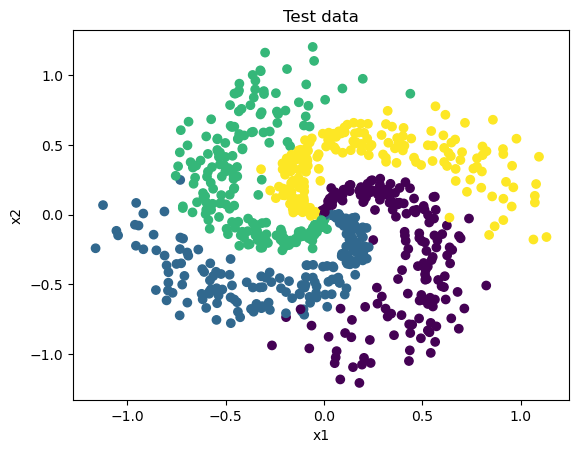

In [8]:
# Shuffle and split data; define X_test, y_test, X_train, y_train

def shuffle_and_split_data(X, y, seed):
	"""
    Helper function to shuffle and split data
  
    Args:
      X: torch.tensor
        Input data
      y: torch.tensor
        Corresponding target variables
      seed: int
        Set seed for reproducibility
  
    Returns:
      X_test: torch.tensor
        Test data [20% of X]
      y_test: torch.tensor
        Labels corresponding to above mentioned test data
      X_train: torch.tensor
        Train data [80% of X]
      y_train: torch.tensor
        Labels corresponding to above mentioned train data
    """
	# Set seed for reproducibility
	torch.manual_seed(seed)
	# Number of samples
	N = X.shape[0]
	# Shuffle data
	shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
	X = X[shuffled_indices]
	y = y[shuffled_indices]

	# Split data into train/test
	test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
	X_test = X[:test_size]
	y_test = y[:test_size]
	X_train = X[test_size:]
	y_train = y[test_size:]

	return X_test, y_test, X_train, y_train

X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test data')
plt.show()

In [9]:
# Train and test DataLoaders

g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 1
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(test_data),
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

In [ ]:
# Finding optimal learning rate

set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [128, 32], K).to(DEVICE)
criterion = "MSELoss"
num_epochs = 1

loss_history = []
learning_rates = np.arange(0.01, 0.2 + 0.01, 0.01)
for i in learning_rates:
	optimizer = optim.SGD(net.parameters(), lr=i)
	loss = net.train_model(criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)
	loss_history.append(loss)

plt.figure()
plt.plot(learning_rates, loss_history)

Random seed 2021 has been set.


  0%|          | 0/2 [00:00<?, ?it/s]


Train Hidden Layer 1 State: tensor([[ 0.4340, -0.2161, -0.8797,  0.6521, -0.8434, -0.4649, -1.1970, -0.1290,
         -0.5670, -0.4810, -0.1233, -0.3018,  0.0215, -0.2365,  0.0313, -0.0945,
         -0.2257,  0.3718, -0.0948, -0.0860,  0.5245, -0.0271, -0.0242, -1.3069,
         -0.5471, -0.7622, -0.2394, -0.6152, -0.3243,  0.1876,  0.4991,  0.3261,
         -0.8395,  0.2319, -0.0239, -0.1192,  0.2954,  0.3045, -0.2359,  0.5192,
         -0.1191, -0.2393, -0.4199, -0.7148,  0.5869,  0.0785,  0.2302, -0.1487,
          0.4298, -0.4477, -0.8390,  0.5150, -0.1088, -0.3342, -0.3041,  0.2007,
         -0.5528, -0.5000, -0.6492,  0.5605, -0.7750,  0.4291,  1.0317,  0.0379,
         -0.1151,  0.5856, -0.2765, -0.4341,  0.3370,  0.0159, -0.5825,  0.1099,
         -0.6271, -0.2869, -0.0554,  0.2263, -0.6031,  0.0069, -0.6107,  0.0946,
         -0.2352,  0.0247, -0.9090, -0.7728,  0.0394, -0.1592, -0.6023,  0.3302,
          0.5571, -0.0924,  0.0523, -0.1095, -1.0603, -0.1690, -0.2863, -0.2890,

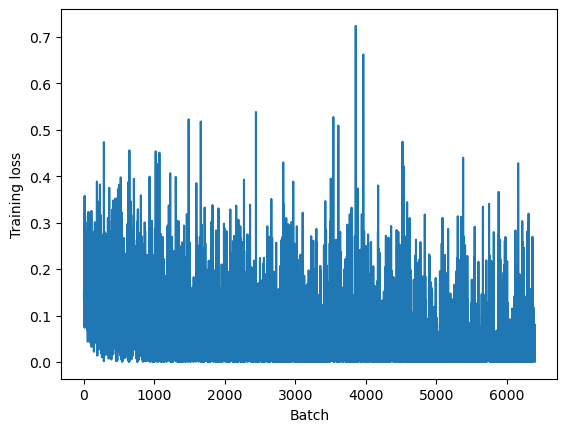


Test Hidden Layer 1 State: tensor([[-0.1684, -0.4139, -0.0277,  ..., -0.3025, -0.4668,  0.4235],
        [ 0.1717, -0.1613, -0.6823,  ..., -0.6698,  0.2425, -0.2461],
        [ 0.0232, -0.1643, -0.5286,  ..., -0.6285, -0.0326, -0.0919],
        ...,
        [ 0.4404, -0.2997, -0.7832,  ..., -0.5847,  0.6944, -0.3399],
        [-0.2615,  0.1034, -0.5707,  ..., -0.8530, -0.4726, -0.1484],
        [ 0.4349, -0.5844, -0.4271,  ..., -0.2672,  0.5928,  0.0323]])
Test Hidden Layer 1 State shape: torch.Size([800, 128])


Test Hidden Layer 1 Output: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4235],
        [0.1717, 0.0000, 0.0000,  ..., 0.0000, 0.2425, 0.0000],
        [0.0232, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4404, 0.0000, 0.0000,  ..., 0.0000, 0.6944, 0.0000],
        [0.0000, 0.1034, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4349, 0.0000, 0.0000,  ..., 0.0000, 0.5928, 0.0323]])
Test Hidden Layer 1 Output shape: torch.Size([800, 128

In [27]:
# Train and Test model

set_seed(SEED)
net = Net(nn.ReLU, X_train.shape[1], [128, 32], K).to(DEVICE)
criterion = "MSELoss"
optimizer = optim.SGD(net.parameters(), lr=0.09)
num_epochs = 2

train_acc, train_states_activities = net.train_model(criterion, optimizer, train_loader, num_epochs=num_epochs, training_plot=True, device=DEVICE)

test_acc, test_states_activities = net.test_model(test_loader, verbose=True, device=DEVICE)

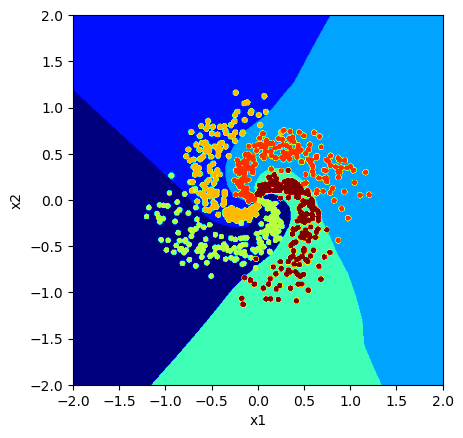

In [49]:
# Graph of sorted spiral data

def sample_grid(M=500, x_max=2.0):
	"""
    Helper function to simulate sample meshgrid
  
    Args:
      M: int
        Size of the constructed tensor with meshgrid
      x_max: float
        Defines range for the set of points
  
    Returns:
      X_all: torch.tensor
        Concatenated meshgrid tensor
    """
	ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max, M),
	                        torch.linspace(-x_max, x_max, M),
	                        indexing="ij")
	X_all = torch.cat([ii.unsqueeze(-1),
	                   jj.unsqueeze(-1)],
	                  dim=-1).view(-1, 2)
	return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
	"""
    Helper function to plot decision map
  
    Args:
      X_all: torch.tensor
        Concatenated meshgrid tensor
      y_pred: torch.tensor
        Labels predicted by the network
      X_test: torch.tensor
        Test data
      y_test: torch.tensor
        Labels of the test data
      M: int
        Size of the constructed tensor with meshgrid
      x_max: float
        Defines range for the set of points
      eps: float
        Decision threshold
  
    Returns:
      Nothing
    """
	decision_map = torch.argmax(y_pred, dim=1)

	for i in range(len(X_test)):
		indices = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
		decision_map[indices] = (K + y_test[i]).long()

	decision_map = decision_map.view(M, M)
	plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
	plt.xlabel('x1')
	plt.ylabel('x2')
	plt.show()
	
X_all = sample_grid()
y_pred = net(X_all.to(DEVICE)).cpu()
plot_decision_map(X_all, y_pred, X_test, y_test)

In [ ]:
# Untrained null_net

set_seed(SEED)
null_net = Net('ReLU()', X_train.shape[1], [128, 32], K).to(DEVICE)

X_all = sample_grid()
y_pred = null_net(X_all.to(DEVICE)).cpu()
plot_decision_map(X_all, y_pred, X_test, y_test)